In [1]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pickle

In [2]:
btvote = pd.read_pickle('../data/btvote_imputed.pkl')
btvote.head()

,vote_19001,vote_19002,vote_19003,vote_19004,vote_19005,vote_19006,vote_19007,vote_19008,vote_19009,vote_19010,...,vote_19236,vote_19237,vote_19238,vote_19239,vote_19240,vote_19241,vote_19242,vote_19243,vote_19244,party
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,CDU/CSU
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,SPD
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,Linke
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,CDU/CSU
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,Linke


# Split data and encode target variable

In [3]:
# Split dataframe in 'data' and 'target'
btvote_data = btvote.drop('party', axis=1)
btvote_target = btvote['party']

# Encode the target variable
label_encoder = preprocessing.LabelEncoder()
btvote_target = label_encoder.fit_transform(btvote_target)

# Setup cross validation

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, make_scorer

# specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# define the scoring function
# We use 'macro' as average as we want to evaluate the performance of each class equally, regardless of the class size
f1 = make_scorer(f1_score, average='macro')

# RandomForestClassifier

## Feature importance analysis

In [5]:
from sklearn.ensemble import RandomForestClassifier

# initialize DecisionTreeClassifier
rf_classifier = RandomForestClassifier(criterion='gini', n_estimators=50, max_depth=40, random_state=42)

# fit the classifier on data
rf_classifier.fit(btvote_data, btvote_target)

# get feature importances
feature_importances = rf_classifier.feature_importances_

# convert to dictionary and sort by importance
rf_feature_importance_dict = {btvote_data.columns[i]: feature_importances[i] for i in range(len(feature_importances))}
rf_sorted_dict = dict(sorted(rf_feature_importance_dict.items(), key=lambda item: item[1], reverse=True))
rf_values = [y for _, y in rf_sorted_dict.items()]

# display feature importances
print({x:y for x, y in rf_sorted_dict.items()})

{'vote_19182': 0.024387607720631383, 'vote_19200': 0.02410030405294585, 'vote_19031': 0.024066191025715642, 'vote_19040': 0.023733179625468, 'vote_19106': 0.02290801270546039, 'vote_19142': 0.018124233493973272, 'vote_19179': 0.015614570030615782, 'vote_19048': 0.015141831294578136, 'vote_19221': 0.014568365598393909, 'vote_19070': 0.013606166215372341, 'vote_19236': 0.013363286347017509, 'vote_19194': 0.013307193651381935, 'vote_19051': 0.01262247056279154, 'vote_19149': 0.012588277567342833, 'vote_19237': 0.012487284937641247, 'vote_19118': 0.012289897209104532, 'vote_19219': 0.0120916697051383, 'vote_19162': 0.012087556305921867, 'vote_19134': 0.011931046926513577, 'vote_19057': 0.011770382317465944, 'vote_19198': 0.011760886878361536, 'vote_19135': 0.011726082822933671, 'vote_19085': 0.011708485637682434, 'vote_19066': 0.011590918623402358, 'vote_19096': 0.010909908568943518, 'vote_19067': 0.010682476658182847, 'vote_19054': 0.01057836373953616, 'vote_19185': 0.010508717899234361, 

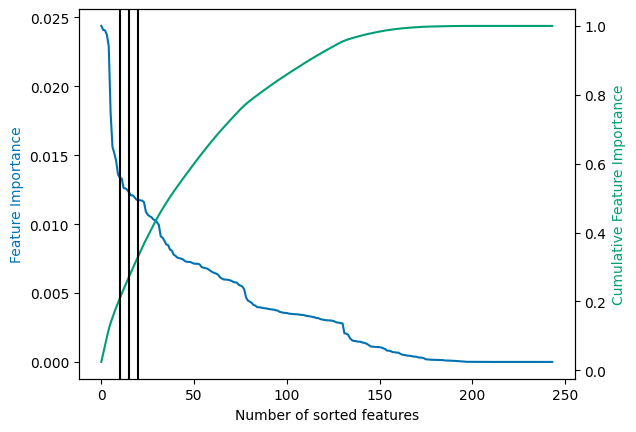

In [6]:
# plot the feature importance
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# plot sorted feature importance values
ax1.plot(rf_values, color='#0072B2')

# calculate and plot cumulative values
rf_cumulative_values = []
cumulative_sum = 0.0
for num in rf_values:
    cumulative_sum += num
    rf_cumulative_values.append(cumulative_sum)
ax2.plot(rf_cumulative_values, color='#009E73')

# set axes labels
ax1.set_xlabel('Number of sorted features')
ax1.set_ylabel('Feature Importance', color='#0072B2')
ax2.set_ylabel('Cumulative Feature Importance', color='#009E73')

# add vertical lines to show where 10, 15 and 20 features would end up in coverage
plt.axvline(x=10, color='#000000')
plt.axvline(x=15, color='#000000')
plt.axvline(x=20, color='#000000')

plt.show()

We see, that with the top 10, 15 or 20 features (three black vertical lines), the feature importance is still relatively high and the cumulative is still very low with approx. 0.3. Only with a feature importance of around 50 we cover half of the total feature importance.

## Evaluation of subset

Compute the cross validated f1 score for the selected values when using...
- RandomForestClassifier (where we performed the Feature Selection on)
- KNNClassifier (the best model of the classification notebook)

for a features size of...
- 10
- 15
- 20

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

results = pd.DataFrame(columns=['Feature size', 'RandomForestClassifier', '6-NeighborsClassifier'])

for feature_size in [10,15,20]:
    # get columns with highest feature importance
    top_columns = list(rf_sorted_dict.keys())[:feature_size]
    subset_data = btvote_data.loc[:, top_columns]

    # compute cross validated macro F1 score for RandomForestClassifier and 6-NN
    score_rf = cross_val_score(RandomForestClassifier(criterion='gini', n_estimators=50, max_depth=40, random_state=42), subset_data, btvote_target, cv=stratified_10_fold_cv, scoring=f1).mean()
    score_knn = cross_val_score(KNeighborsClassifier(n_neighbors=6, weights='distance'), subset_data, btvote_target, cv=stratified_10_fold_cv, scoring=f1).mean()

    # save results
    results.loc[len(results)] = [feature_size, score_rf, score_knn]

# show results
results

,Feature size,RandomForestClassifier,6-NeighborsClassifier
0,10.0,0.823586,0.824949
1,15.0,0.828268,0.851722
2,20.0,0.841902,0.870474


Even though we didn't cover much of the feature importance, as seen in the previous visualization, we still result in good F1 scores. Even though the top features were selected using the RandomForest classifier, the KNN still performs as good or better. The optimal F1 score of the classification in the previous notebook was 0.87 using a 6-NN Classifier. With a feature size of 20 we come close to that score, but for our presentation we would prefer a smaller feature size.

# DecisionTree analysis

## DecisionTree visualization

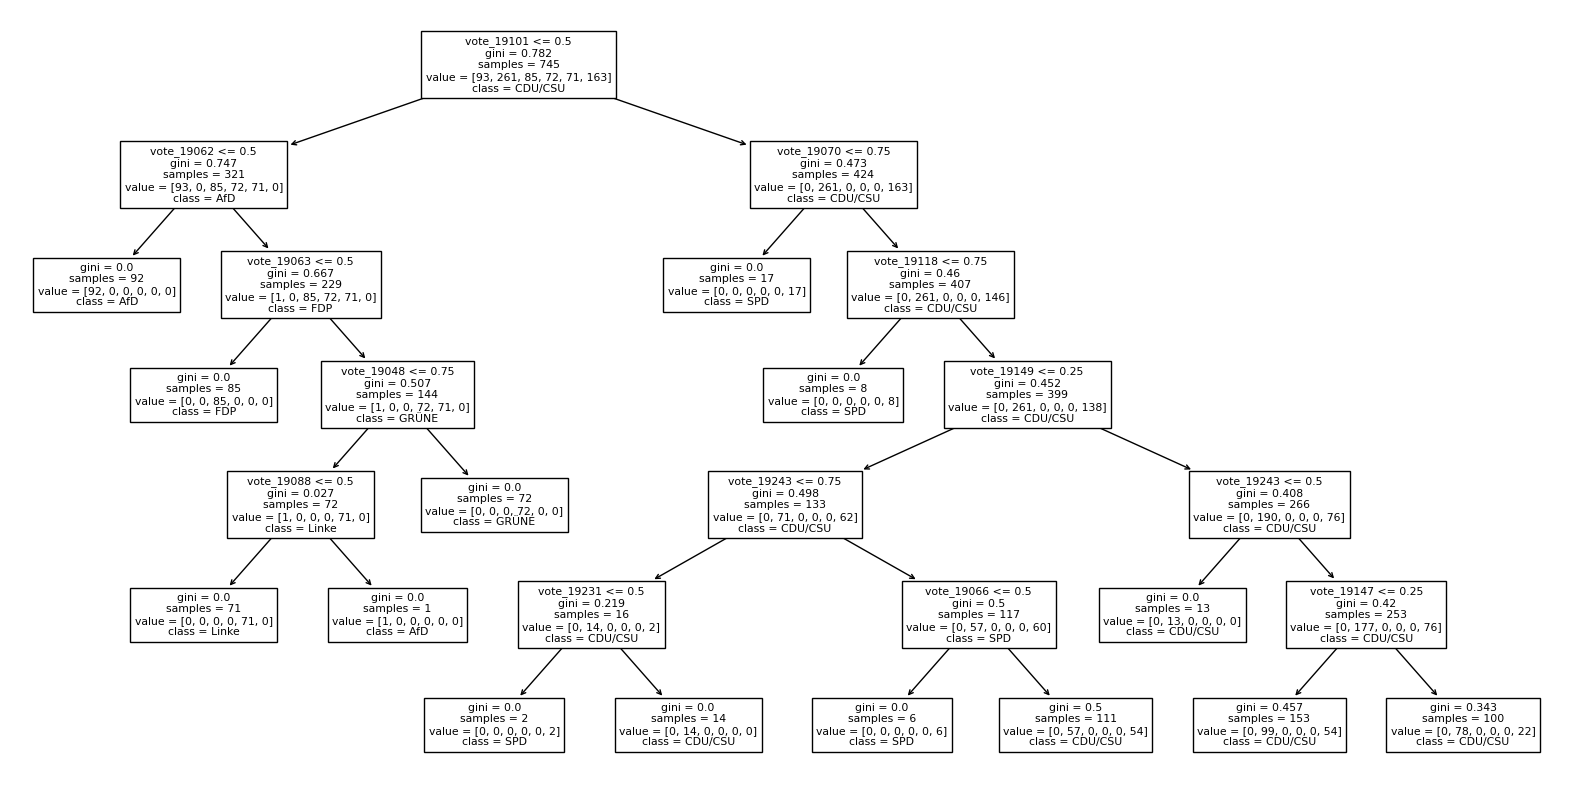

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# initialize DecisionTreeClassifier
# Note: We reduce max_depth so that we can understand the tree
dt_classifier = DecisionTreeClassifier(max_depth=6, random_state=42)

# fit the classifier on data
dt_classifier.fit(btvote_data, btvote_target)

plt.figure(figsize=(20,10))
plot_tree(dt_classifier, feature_names=btvote_data.columns, class_names=label_encoder.classes_)
plt.show()

Now we perform the same analysis as with the RandomForests classifier using the top features selected by the DecisionTree.

## Feature Importance analysis

In [11]:
# initialize DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(max_depth=15, random_state=42)

# fit the classifier on data
dt_classifier.fit(btvote_data, btvote_target)

# get feature importances
feature_importances = dt_classifier.feature_importances_

# convert to dictionary and sort by importance
dt_feature_importance_dict = {btvote_data.columns[i]: feature_importances[i] for i in range(len(feature_importances))}
dt_sorted_dict = dict(sorted(dt_feature_importance_dict.items(), key=lambda item: item[1], reverse=True))
dt_values = [y for _, y in dt_sorted_dict.items()]

# display feature importances
print({x:y for x, y in dt_sorted_dict.items()})

{'vote_19101': 0.3122960245588343, 'vote_19062': 0.1904484949803899, 'vote_19063': 0.1749073278432897, 'vote_19048': 0.1556328762035949, 'vote_19070': 0.029414245523413384, 'vote_19118': 0.014709290994459364, 'vote_19243': 0.014169591639897894, 'vote_19149': 0.012655159592538004, 'vote_19231': 0.010680959766278132, 'vote_19066': 0.009646260319113219, 'vote_19216': 0.008879834491804515, 'vote_19237': 0.006402609541096242, 'vote_19223': 0.005406013044104816, 'vote_19036': 0.005048969608096915, 'vote_19147': 0.0046846590474605805, 'vote_19179': 0.004415435520385655, 'vote_19088': 0.004322289931725115, 'vote_19018': 0.003563791394029909, 'vote_19011': 0.0032957830508539743, 'vote_19015': 0.0029221115031381013, 'vote_19206': 0.0029221115031381013, 'vote_19115': 0.0028772446890956292, 'vote_19174': 0.002704610007749862, 'vote_19102': 0.0024572365115305347, 'vote_19178': 0.0023636275015674587, 'vote_19148': 0.0022102109826868093, 'vote_19151': 0.002101446872631182, 'vote_19154': 0.00197060063

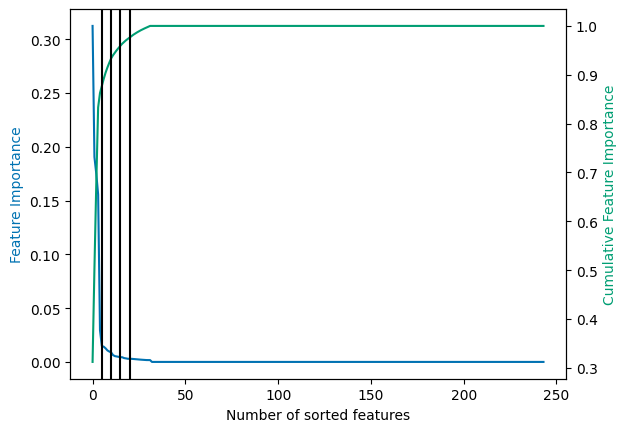

In [12]:
# plot the feature importance
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# plot sorted feature importance values
ax1.plot(dt_values, color='#0072B2')

# calculate and plot cumulative values
dt_cumulative_values = []
cumulative_sum = 0.0
for num in dt_values:
    cumulative_sum += num
    dt_cumulative_values.append(cumulative_sum)
ax2.plot(dt_cumulative_values, color='#009E73')

# set axes labels
ax1.set_xlabel('Number of sorted features')
ax1.set_ylabel('Feature Importance', color='#0072B2')
ax2.set_ylabel('Cumulative Feature Importance', color='#009E73')

# add vertical lines to show where 5, 10, 15 and 20 features would end up in coverage
plt.axvline(x=5, color='#000000')
plt.axvline(x=10, color='#000000')
plt.axvline(x=15, color='#000000')
plt.axvline(x=20, color='#000000')

plt.show()

We see, that with the top 5 features, we already cover about 90% percent of the overall feature importance. From a feature size of 10 on, there is no large improvement in the cumulative feature importance. The feature importance values are much more unevenly distributed.

## Evaluation of subset

Compute the cross validated f1 score for the selected values when using...
- DecisionTreeClassifier (where we performed the Feature Selection on)
- KNNClassifier (the best model of the classification notebook)

for a features size of...
- 5
- 6
- 7
- 8
- 9
- 10
- 15
- 20

In [13]:
results = pd.DataFrame(columns=['Feature size', 'DecisionTreeClassifier', '6-NeighborsClassifier'])

for feature_size in [5,6,7,8,9,10,15,20]:
    # get columns with highest feature importance
    top_columns = list(dt_sorted_dict.keys())[:feature_size]
    subset_data = btvote_data.loc[:, top_columns]

    # compute cross validated macro F1 score for DecisionTreeClassifier and 6-NN
    score_dt = cross_val_score(DecisionTreeClassifier(max_depth=15, random_state=42), subset_data, btvote_target, cv=stratified_10_fold_cv, scoring=f1).mean()
    score_knn = cross_val_score(KNeighborsClassifier(n_neighbors=6, weights='distance'), subset_data, btvote_target, cv=stratified_10_fold_cv, scoring=f1).mean()

    # save results
    results.loc[len(results)] = [feature_size, score_dt, score_knn]

# show results
results

,Feature size,DecisionTreeClassifier,5-NeighborsClassifier
0,5.0,0.824523,0.824523
1,6.0,0.836236,0.836923
2,7.0,0.838328,0.836923
3,8.0,0.863964,0.879285
4,9.0,0.865469,0.881024
5,10.0,0.849179,0.879871
6,15.0,0.867011,0.881383
7,20.0,0.867178,0.878440


Using more than the top 8 features doesn't significantly improve the F1 score. Again, the KNN performs better than the model we selected the top features from.

The 6-NN Classifier with the top 9 features results in an F1 score of 0.88, which is better than the 6-NN we evaluated on all features in the previous notebook.

# Summary

Since we've seen, that some of those features (votes) can not really be used for our presentation, we will take the 15 features with the highest performance and for those find the 10 best, that can be used in our presentation.

# Create and save reduced dataset

In [14]:
# get columns with highest feature importance
best_features = list(dt_sorted_dict.keys())[:10]
btvote_data_subset = btvote_data.loc[:, best_features]
btvote_data_subset

,vote_19101,vote_19062,vote_19063,vote_19048,vote_19070,vote_19118,vote_19243,vote_19149,vote_19231,vote_19066
0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
2,0.0,1.0,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,1.0,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
740,0.0,1.0,0.0,0.5,1.0,0.0,0.0,0.0,0.0,0.5
741,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
742,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
743,0.0,1.0,1.0,0.5,1.0,0.0,0.0,1.0,0.0,0.0


Get vote topic for vote_ids: 

In [15]:
# load vote table
vote_char = pd.read_csv('../data/vote_characteristics_V2_19492021.tab', sep='\t')

# format vote ids of selected features
best_features_formatted = [int(element.replace('vote_','')) for element in best_features]

pd.set_option('display.max_colwidth', None)
display(vote_char[vote_char['vote_id'].isin(best_features_formatted)][['vote_id','vote_date','vote_title']])

,vote_id,vote_date,vote_title
2234,19048,2018-10-19,"Antrag der Abgeordneten Kai Gehring, Dr. Konstantin von Notz, Filiz Polat, weiterer Abgeordneter und der Fraktion B��NDNIS 90/DIE GR��NEN Einsatz f��r Religions- und Weltanschauungsfreiheit weltweit verst��rken (Drs.19/4559)"
2248,19062,2018-11-29,"Gesetzentwurf der Bundesregierung Entwurf eines Gesetzes zur ��nderung des Grundgesetzes (Artikel 104c, 104d, 125c , 143e) (Drs.19/3440 und 19/6144)"
2249,19063,2018-11-29,"��nderungsantrag der Abgeordneten Lisa Paus, Chris K��hn, Anja Hajduk, weiterer Abgeordneter und der Fraktion B��NDNIS 90/DIE GR��NEN zu der zweiten Beratung des Gesetzentwurfs der Bundesregierung Entwurf eines Gesetzes zur steuerlichen F��rderung des Mietwohnungsneubaus (Drs.19/4949, 19/5417, 19/5647 Nr. 15, 19/6140 und 19/6156)"
2252,19066,2018-11-29,"Gesetzentwurf der Fraktionen der CDU/CSU und SPD Entwurf eines Vierten Gesetzes zur ��nderung des Tierschutzgesetzes (Drs.19/5522, und 19/6000)"
2256,19070,2019-01-18,"Gesetzentwurf der Bundesregierung Entwurf eines Gesetzes zur Einstufung Georgiens, der Demokratischen Volksrepublik Algerien, des K��nigreichs Marokko und der Tunesischen Republik als sichere Herkunftsstaaten (Drs.19/5314 und 19/6538)"
2287,19101,2019-06-07,Gesetzentwurf der Bundesregierung Entwurf eines Fachkr��fteeinwanderungsgesetzes (Drs.19/8285 und 19/10714)
2304,19118,2019-10-24,"Beschlussempfehlung des Ausw��rtigen Ausschusses (3. Ausschuss) zu dem Antrag der Bundesregierung Einsatz bewaffneter deutscher Streitkr��fte - Stabilisierung sichern, Wiedererstarken des IS verhindern, Vers��hnung f��rdern in Irak und Syrien (Drs.19/13290 und 19/14287)"
2335,19149,2020-01-16,"Namentliche Schlussabstimmung ��ber den Gesetzentwurf der Abgeordneten Annalena Baerbock, Karin Maag, Hilde Mattheis, Katja Kipping und weiterer AbgeordneterEntwurf eines Gesetzes zur St��rkung der Entscheidungsbereitschaft bei der Organspende (Drs.19/11087 und 19/16214)"
2417,19231,2021-06-10,"Gesetzentwurf der Bundesregierung Entwurf eines Gesetzes zur Anpassung des Verfassungsschutzrechts (Drs.19/24785, 19/24900 und 19/30477)"
2429,19243,2021-08-25,Antrag der Fraktionen der CDU/CSU und SPD Feststellung des Fortbestehens der epidemischen Lage von nationaler Tragweite Drs. 19/32091 (Drs. 19/32091)


# Fit and save model

Fit model on subset data and save as pickle file.

In [16]:
# define the best model
best_model = KNeighborsClassifier(n_neighbors=6, weights='distance')

# train model on subset data
best_model.fit(btvote_data_subset, btvote_target)

# save model as pickle file
with open('../data/classifier.pkl','wb') as f:
    pickle.dump(best_model,f)

# Further 6-NN analysis

Calculate accuracy, precision and recall in addition to the F1-score:

In [19]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Define the scorers
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1_score': make_scorer(f1_score, average='macro')
}

# Perform cross-validation with multiple scoring metrics
cv_results = cross_validate(best_model, btvote_data_subset, btvote_target, cv=stratified_10_fold_cv, scoring=scoring)

# Print the results for each metric
print('Mean values for each score:')
print('- Accuracy:', cv_results['test_accuracy'].mean())
print('- Precision:', cv_results['test_precision'].mean())
print('- Recall:', cv_results['test_recall'].mean())
print('- F1-score:', cv_results['test_f1_score'].mean())

Mean values for each score:
- Accuracy: 0.8147387387387388
- Precision: 0.8865564507128842
- Recall: 0.8796867144293614
- F1-score: 0.8798705824074764


We see that the results for all scores are more or less the same as when we used all features in the previous notebook.

Plot confusion matrix for different train/test-split combinations:

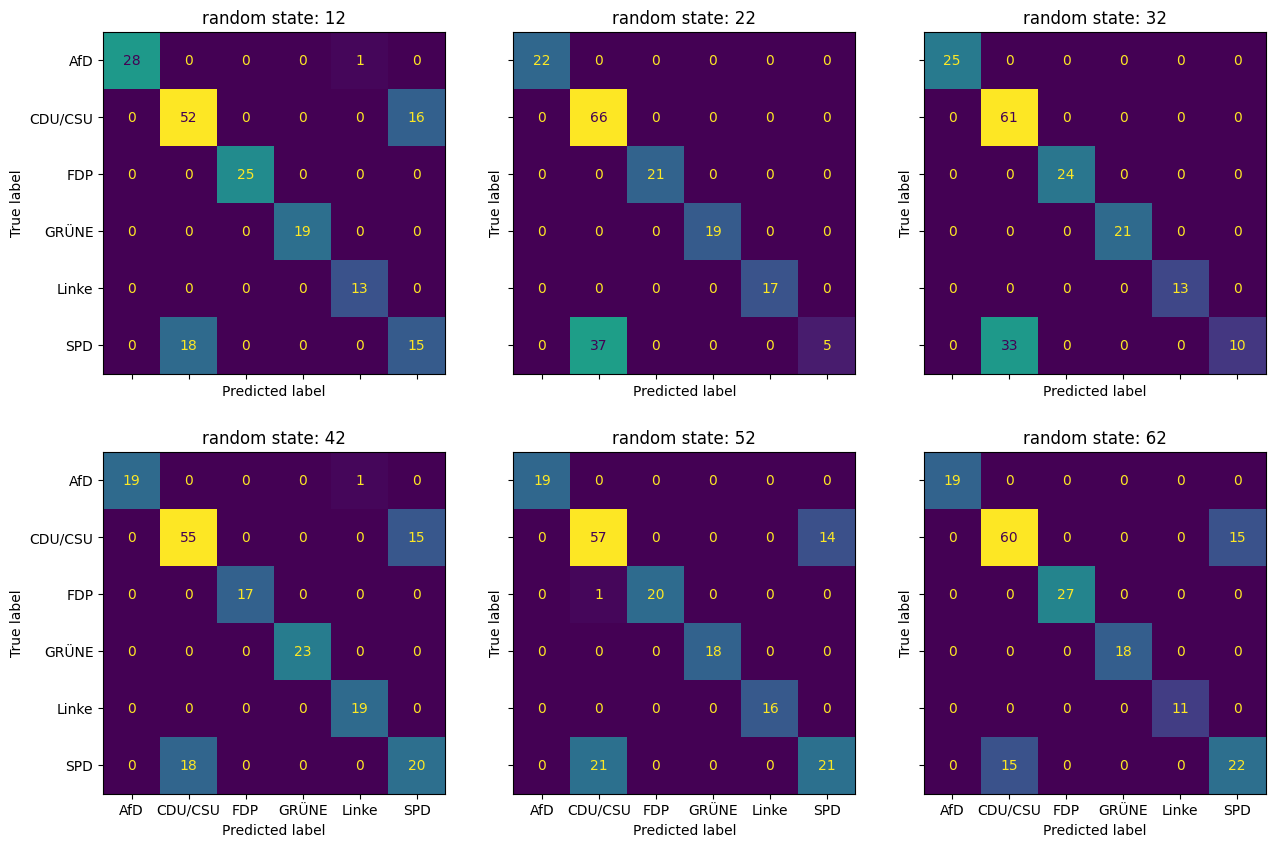

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,10))

# define a list of random states
random_states = [12,22,32,42,52,62]

for ax, random_state in zip(axs.flatten(), random_states):
    
    # Create train and test split
    btvote_data_train, btvote_data_test, btvote_target_train, btvote_target_test = train_test_split(btvote_data_subset, btvote_target, random_state=random_state)

    # fit classifier
    best_model.fit(btvote_data_train, btvote_target_train)

    # predict test data
    prediction = best_model.predict(btvote_data_test)

    # plot confusion matrix
    ConfusionMatrixDisplay(confusion_matrix(btvote_target_test, prediction), display_labels=label_encoder.classes_).plot(ax=ax, colorbar=False)

    # add random state as information
    ax.set_title('random state: {}'.format(random_state))

plt.show()

For six random train/test examples, we see again that the difficulty always lies with differentiating between CDU/CDU and SPD. This is the same Understanding we received when evaluating on all features.